In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_dt1h_default_control.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_dt1h_default_control.json')
n_clusters = 30

Get results:

In [7]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/results_sim_38_noControls.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [18]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [19]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


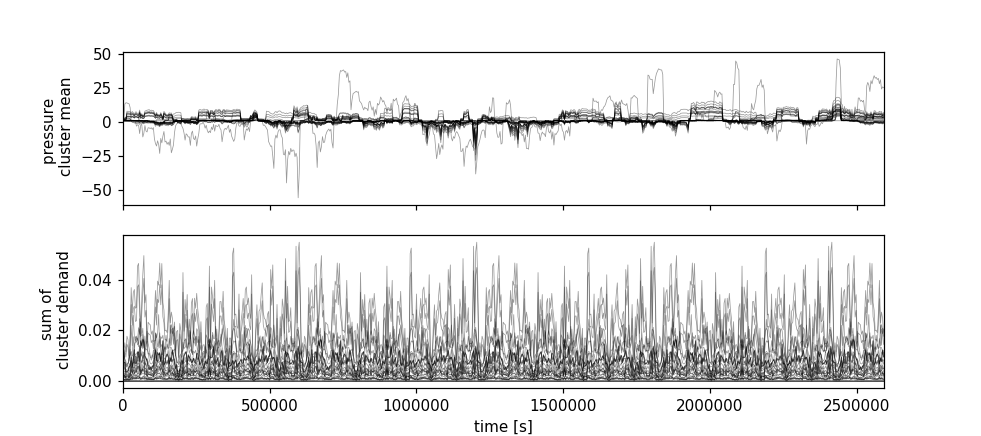

In [20]:
fig, ax = plt.subplots(2,1,figsize=(9,4), sharex=True)
jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[0].set_ylabel('pressure \n cluster mean')


jun_cl_demand_sum.plot(ax=ax[1], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[1].set_ylabel('sum of \n cluster demand')

ax[1].set_xlabel('time [s]')
plt.show()

### Tanks

In [8]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


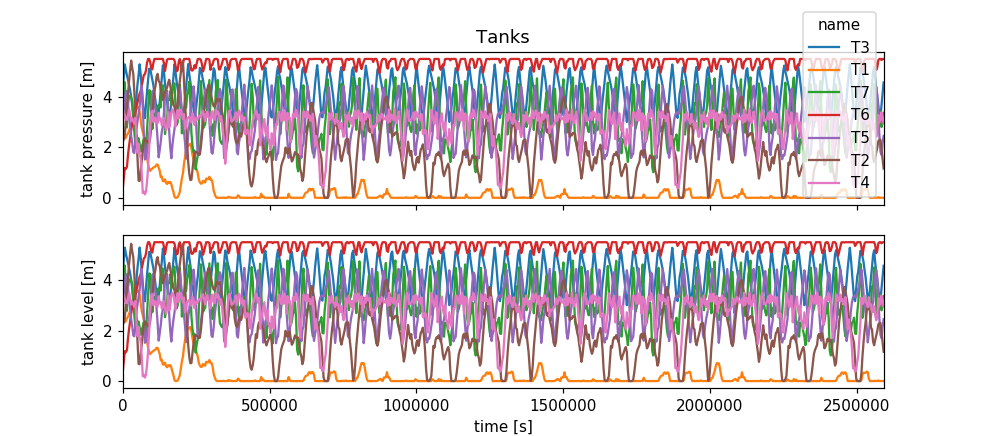

Text(0.5, 0, 'time [s]')

In [9]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(9,4))
tank_press.plot(ax=ax[0])
ax[0].set_title('Tanks')
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

### Reservoirs

In [23]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


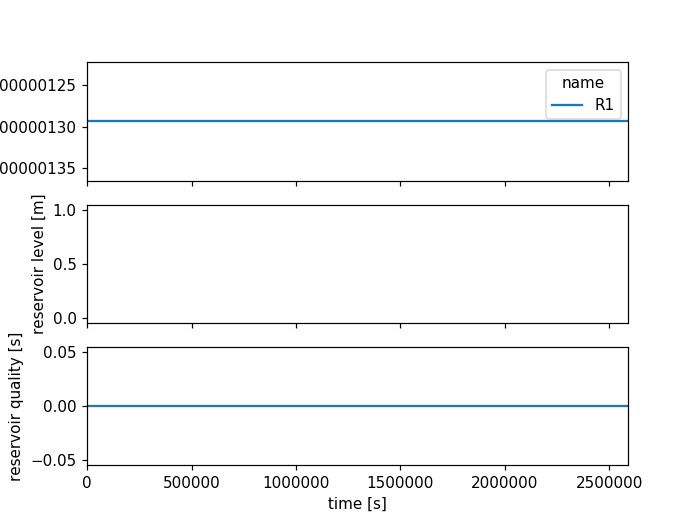

Text(0.5, 0, 'time [s]')

In [24]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [25]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]
head_pump_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

head_pump_speed_corr = head_pump_speed*head_pump_status

<IPython.core.display.Javascript object>


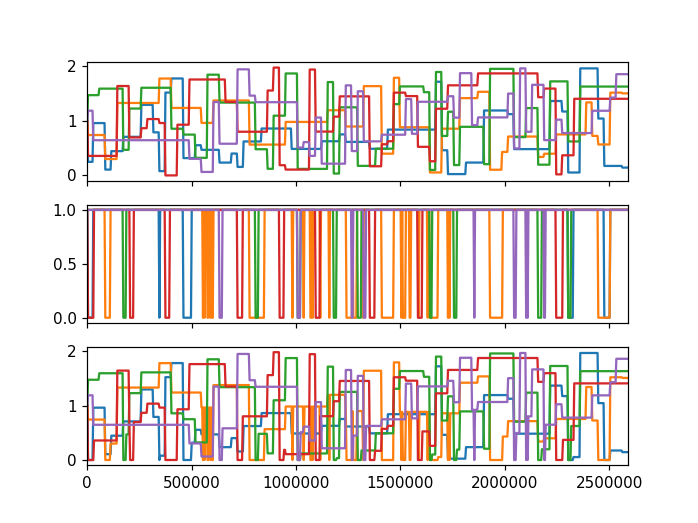

In [26]:
fig, ax = plt.subplots(3,1, sharex=True)
head_pump_speed.plot(ax=ax[0],legend=False)
head_pump_status.plot(ax=ax[1],legend=False)
head_pump_speed_corr.plot(ax=ax[2],legend=False)

In [27]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,59.550647,30.478089,57.367366,30.471183,20.703551
3600,0.000000,4.247719,158.014252,0.000000,29.601677
7200,0.000000,3.318262,159.097846,0.000000,26.056161


<IPython.core.display.Javascript object>


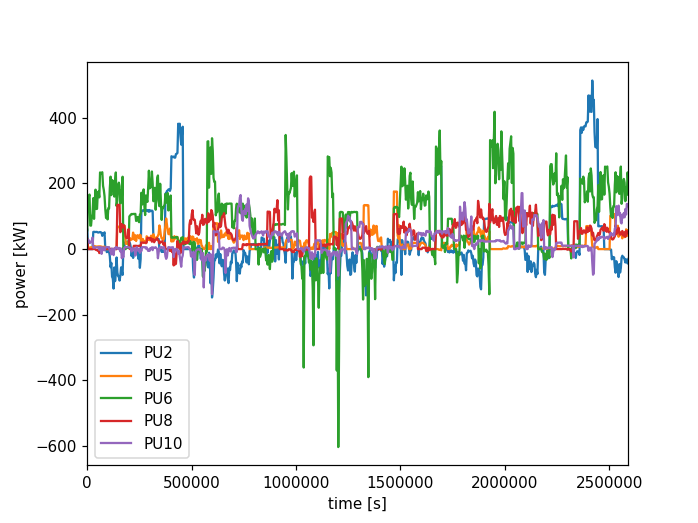

Text(0.5, 0, 'time [s]')

In [28]:
fig, ax = plt.subplots()
pump_energy.plot(ax=ax)
ax.set_ylabel('power [kW]')
ax.set_xlabel('time [s]')

### Valves

In [29]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

PRValve_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


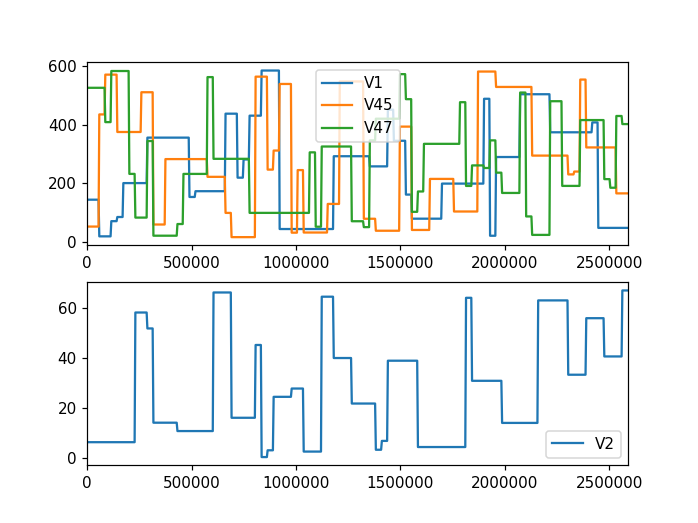

In [30]:
fig, ax = plt.subplots(2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [33]:
state_dict = {#'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed_corr,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

aux_output_dict = {'pump_energy': pump_energy,
                  'jun_cl_press_mean': jun_cl_press_mean}

aux_outputs = pd.concat(aux_output_dict.values(), axis=1, keys=aux_output_dict.keys())

### Neural Network I/O

Outputs of the neural network.

Note: we are learning the next state of the system and the current aux_outputs (pump energy)

In [54]:
dsys_states = sys_states.diff(axis=0)
dsys_states_next = dsys_states.shift(-1, axis=0)
sys_states_next = sys_states.shift(-1, axis=0)

nn_output_dict = {'sys_states': dsys_states_next,
                 #'sys_states': sys_states_next,
                 'aux_outputs': aux_outputs,
                 }
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

In [55]:
nn_output.head(3)

sys_states                                                             \
     tank_press                                                              
             T3        T1       T7        T6        T5        T2        T4   
0      0.545074 -0.328859  0.53912  0.313246  0.565379 -0.175185  0.414272   
3600  -0.116719 -0.506978  0.48491  0.003274 -0.683670 -0.442345  1.776701   
7200  -0.093668 -0.498839  0.00000  0.000000 -0.466688 -0.434569  1.762628   

     aux_outputs                         ...                              \
     pump_energy                         ... jun_cl_press_mean             
             PU2        PU5         PU6  ...                20        21   
0      59.550647  30.478089   57.367366  ...          1.128958  2.409093   
3600    0.000000   4.247719  158.014252  ...          0.860478  3.058638   
7200    0.000000   3.318262  159.097846  ...          0.867479  3.096821   

                                                                            \
                                                                             
            22        23        24        25        26        27        28   
0     1.146895  1.127380  1.181617  1.000614  1.142968  1.020294  2.133063   
3600  1.092526  1.272461  0.931455  1.006405  0.587159  1.820045  2.529338   
7200  1.084620  1.417892  0.931679  1.006405  0.587357  1.856175  2.562855   

                
                
            29  
0     1.001186  
3600  1.756562  
7200  1.801060  

[3 rows x 42 columns]

Inputs of the neural network:

In [56]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys(), names=['type', 'name', 'index'])

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (721, 46)


Filter inputs and outputs:

In [57]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (720, 46)


### Compare to external output function:

This function is used to create the complete dataset for training.

In [229]:
file_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/results_sim_14.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_15_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_16_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_17_try.pkl'
            ]

n_arx = 0
nn_input_ext, nn_output_ext = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)

In [38]:
nn_output.shape

(720, 42)

In [231]:
similar_inputs=((nn_input_ext-nn_input)==0).all().all()
print('inputs are identical: {}'.format(similar_inputs))

similar_outputs=((nn_output_ext-nn_output)==0).all().all()
print('outputs are identical: {}'.format(similar_outputs))

inputs are identical: True
outputs are identical: True


### Normalize Data:

In [58]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [60]:
X_train.shape

(576, 46)

# Neural Network

## Create Model

In [61]:
n_layer = 4
n_units = 50
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2350      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 42)                2142      
Total params: 9,592
Trainable params: 9,592
Non-trainable params: 0
_________________________________________________________________


## Train model

In [62]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [63]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=100, 
                    epochs=1000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 576 samples, validate on 144 samples
Epoch 1/1000
576/576 [==============================] - 1s 2ms/sample - loss: 0.1336 - val_loss: 0.0798
Epoch 2/1000
576/576 [==============================] - 0s 231us/sample - loss: 0.0765 - val_loss: 0.0586
Epoch 3/1000
576/576 [==============================] - 0s 194us/sample - loss: 0.0577 - val_loss: 0.0467
Epoch 4/1000
576/576 [==============================] - 0s 209us/sample - loss: 0.0471 - val_loss: 0.0396
Epoch 5/1000
576/576 [==============================] - 0s 174us/sample - loss: 0.0410 - val_loss: 0.0353
Epoch 6/1000
576/576 [==============================] - 0s 143us/sample - loss: 0.0370 - val_loss: 0.0324
Epoch 7/1000
576/576 [==============================] - 0s 186us/sample - loss: 0.0341 - val_loss: 0.0300
Epoch 8/1000
576/576 [==============================] - 0s 139us/sample - loss: 0.0315 - val_loss: 0.0276
Epoch 9/1000
576/576 [==============================] - 0s 135us/sample - loss: 0.0291 - val_loss: 0.0256
Ep

576/576 [==============================] - 0s 220us/sample - loss: 0.0077 - val_loss: 0.0076
Epoch 154/1000
576/576 [==============================] - 0s 201us/sample - loss: 0.0077 - val_loss: 0.0077
Epoch 155/1000
576/576 [==============================] - 0s 190us/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 156/1000
576/576 [==============================] - 0s 212us/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 157/1000
576/576 [==============================] - 0s 179us/sample - loss: 0.0076 - val_loss: 0.0078
Epoch 158/1000
576/576 [==============================] - 0s 170us/sample - loss: 0.0078 - val_loss: 0.0078
Epoch 159/1000
576/576 [==============================] - 0s 146us/sample - loss: 0.0077 - val_loss: 0.0076
Epoch 160/1000
576/576 [==============================] - 0s 167us/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 161/1000
576/576 [==============================] - 0s 172us/sample - loss: 0.0075 - val_loss: 0.0076
Epoch 162/1000
576/576 [===================

Epoch 229/1000
576/576 [==============================] - 0s 132us/sample - loss: 0.0068 - val_loss: 0.0074
Epoch 230/1000
576/576 [==============================] - 0s 112us/sample - loss: 0.0067 - val_loss: 0.0071
Epoch 231/1000
576/576 [==============================] - 0s 112us/sample - loss: 0.0067 - val_loss: 0.0070
Epoch 232/1000
576/576 [==============================] - 0s 110us/sample - loss: 0.0066 - val_loss: 0.0070
Epoch 233/1000
576/576 [==============================] - 0s 109us/sample - loss: 0.0066 - val_loss: 0.0071
Epoch 234/1000
576/576 [==============================] - 0s 124us/sample - loss: 0.0067 - val_loss: 0.0072
Epoch 235/1000
576/576 [==============================] - 0s 122us/sample - loss: 0.0067 - val_loss: 0.0074
Epoch 236/1000
576/576 [==============================] - 0s 146us/sample - loss: 0.0068 - val_loss: 0.0071
Epoch 237/1000
576/576 [==============================] - 0s 116us/sample - loss: 0.0066 - val_loss: 0.0069
Epoch 238/1000
576/576 [====

Epoch 305/1000
576/576 [==============================] - 0s 120us/sample - loss: 0.0059 - val_loss: 0.0065
Epoch 306/1000
576/576 [==============================] - 0s 118us/sample - loss: 0.0057 - val_loss: 0.0064
Epoch 307/1000
576/576 [==============================] - 0s 114us/sample - loss: 0.0058 - val_loss: 0.0064
Epoch 308/1000
576/576 [==============================] - 0s 117us/sample - loss: 0.0057 - val_loss: 0.0064
Epoch 309/1000
576/576 [==============================] - 0s 114us/sample - loss: 0.0057 - val_loss: 0.0064
Epoch 310/1000
576/576 [==============================] - 0s 106us/sample - loss: 0.0057 - val_loss: 0.0065
Epoch 311/1000
576/576 [==============================] - 0s 115us/sample - loss: 0.0058 - val_loss: 0.0066
Epoch 312/1000
576/576 [==============================] - 0s 183us/sample - loss: 0.0058 - val_loss: 0.0067
Epoch 313/1000
576/576 [==============================] - 0s 119us/sample - loss: 0.0057 - val_loss: 0.0064
Epoch 314/1000
576/576 [====

Epoch 381/1000
576/576 [==============================] - 0s 166us/sample - loss: 0.0050 - val_loss: 0.0060
Epoch 382/1000
576/576 [==============================] - 0s 186us/sample - loss: 0.0051 - val_loss: 0.0060
Epoch 383/1000
576/576 [==============================] - 0s 161us/sample - loss: 0.0050 - val_loss: 0.0058
Epoch 384/1000
576/576 [==============================] - 0s 161us/sample - loss: 0.0050 - val_loss: 0.0060
Epoch 385/1000
576/576 [==============================] - 0s 173us/sample - loss: 0.0050 - val_loss: 0.0058
Epoch 386/1000
576/576 [==============================] - 0s 170us/sample - loss: 0.0051 - val_loss: 0.0061
Epoch 387/1000
576/576 [==============================] - 0s 178us/sample - loss: 0.0050 - val_loss: 0.0060
Epoch 388/1000
576/576 [==============================] - 0s 166us/sample - loss: 0.0052 - val_loss: 0.0060
Epoch 389/1000
576/576 [==============================] - 0s 169us/sample - loss: 0.0052 - val_loss: 0.0060
Epoch 390/1000
576/576 [====

Epoch 457/1000
576/576 [==============================] - 0s 235us/sample - loss: 0.0045 - val_loss: 0.0059
Epoch 458/1000
576/576 [==============================] - 0s 191us/sample - loss: 0.0046 - val_loss: 0.0055
Epoch 459/1000
576/576 [==============================] - 0s 200us/sample - loss: 0.0046 - val_loss: 0.0056
Epoch 460/1000
576/576 [==============================] - 0s 170us/sample - loss: 0.0045 - val_loss: 0.0056
Epoch 461/1000
576/576 [==============================] - 0s 160us/sample - loss: 0.0045 - val_loss: 0.0056
Epoch 462/1000
576/576 [==============================] - 0s 155us/sample - loss: 0.0045 - val_loss: 0.0056
Epoch 463/1000
576/576 [==============================] - 0s 119us/sample - loss: 0.0046 - val_loss: 0.0057
Epoch 464/1000
576/576 [==============================] - 0s 107us/sample - loss: 0.0046 - val_loss: 0.0054
Epoch 465/1000
576/576 [==============================] - 0s 109us/sample - loss: 0.0045 - val_loss: 0.0055
Epoch 466/1000
576/576 [====

Epoch 533/1000
576/576 [==============================] - 0s 184us/sample - loss: 0.0041 - val_loss: 0.0051
Epoch 534/1000
576/576 [==============================] - 0s 157us/sample - loss: 0.0041 - val_loss: 0.0052
Epoch 535/1000
576/576 [==============================] - 0s 176us/sample - loss: 0.0041 - val_loss: 0.0052
Epoch 536/1000
576/576 [==============================] - 0s 178us/sample - loss: 0.0040 - val_loss: 0.0051
Epoch 537/1000
576/576 [==============================] - 0s 173us/sample - loss: 0.0040 - val_loss: 0.0052
Epoch 538/1000
576/576 [==============================] - 0s 168us/sample - loss: 0.0040 - val_loss: 0.0052
Epoch 539/1000
576/576 [==============================] - 0s 158us/sample - loss: 0.0040 - val_loss: 0.0052
Epoch 540/1000
576/576 [==============================] - 0s 175us/sample - loss: 0.0040 - val_loss: 0.0052
Epoch 541/1000
576/576 [==============================] - 0s 197us/sample - loss: 0.0040 - val_loss: 0.0056
Epoch 542/1000
576/576 [====

Epoch 609/1000
576/576 [==============================] - 0s 141us/sample - loss: 0.0037 - val_loss: 0.0050
Epoch 610/1000
576/576 [==============================] - 0s 126us/sample - loss: 0.0037 - val_loss: 0.0050
Epoch 611/1000
576/576 [==============================] - 0s 105us/sample - loss: 0.0037 - val_loss: 0.0051
Epoch 612/1000
576/576 [==============================] - 0s 125us/sample - loss: 0.0037 - val_loss: 0.0049
Epoch 613/1000
576/576 [==============================] - 0s 110us/sample - loss: 0.0037 - val_loss: 0.0049
Epoch 614/1000
576/576 [==============================] - 0s 107us/sample - loss: 0.0036 - val_loss: 0.0049
Epoch 615/1000
576/576 [==============================] - 0s 129us/sample - loss: 0.0036 - val_loss: 0.0049
Epoch 616/1000
576/576 [==============================] - 0s 108us/sample - loss: 0.0038 - val_loss: 0.0050
Epoch 617/1000
576/576 [==============================] - 0s 117us/sample - loss: 0.0039 - val_loss: 0.0050
Epoch 618/1000
576/576 [====

Epoch 685/1000
576/576 [==============================] - 0s 183us/sample - loss: 0.0035 - val_loss: 0.0046
Epoch 686/1000
576/576 [==============================] - 0s 152us/sample - loss: 0.0035 - val_loss: 0.0050
Epoch 687/1000
576/576 [==============================] - 0s 158us/sample - loss: 0.0035 - val_loss: 0.0050
Epoch 688/1000
576/576 [==============================] - 0s 161us/sample - loss: 0.0035 - val_loss: 0.0047
Epoch 689/1000
576/576 [==============================] - 0s 115us/sample - loss: 0.0035 - val_loss: 0.0047
Epoch 690/1000
576/576 [==============================] - 0s 124us/sample - loss: 0.0034 - val_loss: 0.0050
Epoch 691/1000
576/576 [==============================] - 0s 109us/sample - loss: 0.0034 - val_loss: 0.0048
Epoch 692/1000
576/576 [==============================] - 0s 112us/sample - loss: 0.0035 - val_loss: 0.0050
Epoch 693/1000
576/576 [==============================] - 0s 110us/sample - loss: 0.0035 - val_loss: 0.0051
Epoch 694/1000
576/576 [====

Epoch 761/1000
576/576 [==============================] - 0s 266us/sample - loss: 0.0031 - val_loss: 0.0046
Epoch 762/1000
576/576 [==============================] - 0s 197us/sample - loss: 0.0031 - val_loss: 0.0046
Epoch 763/1000
576/576 [==============================] - 0s 116us/sample - loss: 0.0031 - val_loss: 0.0048
Epoch 764/1000
576/576 [==============================] - 0s 115us/sample - loss: 0.0032 - val_loss: 0.0050
Epoch 765/1000
576/576 [==============================] - 0s 154us/sample - loss: 0.0033 - val_loss: 0.0046
Epoch 766/1000
576/576 [==============================] - 0s 195us/sample - loss: 0.0033 - val_loss: 0.0049
Epoch 767/1000
576/576 [==============================] - 0s 200us/sample - loss: 0.0033 - val_loss: 0.0047
Epoch 768/1000
576/576 [==============================] - 0s 223us/sample - loss: 0.0033 - val_loss: 0.0044
Epoch 769/1000
576/576 [==============================] - 0s 185us/sample - loss: 0.0031 - val_loss: 0.0046
Epoch 770/1000
576/576 [====

Epoch 837/1000
576/576 [==============================] - 0s 266us/sample - loss: 0.0029 - val_loss: 0.0043
Epoch 838/1000
576/576 [==============================] - 0s 270us/sample - loss: 0.0029 - val_loss: 0.0044
Epoch 839/1000
576/576 [==============================] - 0s 161us/sample - loss: 0.0029 - val_loss: 0.0043
Epoch 840/1000
576/576 [==============================] - 0s 166us/sample - loss: 0.0029 - val_loss: 0.0043
Epoch 841/1000
576/576 [==============================] - 0s 182us/sample - loss: 0.0029 - val_loss: 0.0043
Epoch 842/1000
576/576 [==============================] - 0s 158us/sample - loss: 0.0029 - val_loss: 0.0045
Epoch 843/1000
576/576 [==============================] - 0s 177us/sample - loss: 0.0029 - val_loss: 0.0046
Epoch 844/1000
576/576 [==============================] - 0s 177us/sample - loss: 0.0029 - val_loss: 0.0043
Epoch 845/1000
576/576 [==============================] - 0s 161us/sample - loss: 0.0028 - val_loss: 0.0043
Epoch 846/1000
576/576 [====

Epoch 913/1000
576/576 [==============================] - 0s 185us/sample - loss: 0.0026 - val_loss: 0.0042
Epoch 914/1000
576/576 [==============================] - 0s 156us/sample - loss: 0.0026 - val_loss: 0.0041
Epoch 915/1000
576/576 [==============================] - 0s 176us/sample - loss: 0.0026 - val_loss: 0.0041
Epoch 916/1000
576/576 [==============================] - 0s 171us/sample - loss: 0.0027 - val_loss: 0.0042
Epoch 917/1000
576/576 [==============================] - 0s 174us/sample - loss: 0.0026 - val_loss: 0.0042
Epoch 918/1000
576/576 [==============================] - 0s 189us/sample - loss: 0.0026 - val_loss: 0.0042
Epoch 919/1000
576/576 [==============================] - 0s 170us/sample - loss: 0.0026 - val_loss: 0.0041
Epoch 920/1000
576/576 [==============================] - 0s 164us/sample - loss: 0.0026 - val_loss: 0.0041
Epoch 921/1000
576/576 [==============================] - 0s 163us/sample - loss: 0.0027 - val_loss: 0.0045
Epoch 922/1000
576/576 [====

Epoch 989/1000
576/576 [==============================] - 0s 119us/sample - loss: 0.0024 - val_loss: 0.0040
Epoch 990/1000
576/576 [==============================] - 0s 108us/sample - loss: 0.0025 - val_loss: 0.0042
Epoch 991/1000
576/576 [==============================] - 0s 142us/sample - loss: 0.0025 - val_loss: 0.0043
Epoch 992/1000
576/576 [==============================] - 0s 161us/sample - loss: 0.0025 - val_loss: 0.0040
Epoch 993/1000
576/576 [==============================] - 0s 170us/sample - loss: 0.0024 - val_loss: 0.0041
Epoch 994/1000
576/576 [==============================] - 0s 168us/sample - loss: 0.0025 - val_loss: 0.0040
Epoch 995/1000
576/576 [==============================] - 0s 213us/sample - loss: 0.0025 - val_loss: 0.0040
Epoch 996/1000
576/576 [==============================] - 0s 160us/sample - loss: 0.0025 - val_loss: 0.0042
Epoch 997/1000
576/576 [==============================] - 0s 181us/sample - loss: 0.0024 - val_loss: 0.0041
Epoch 998/1000
576/576 [====

## Evaluate model

In [64]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [65]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [66]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


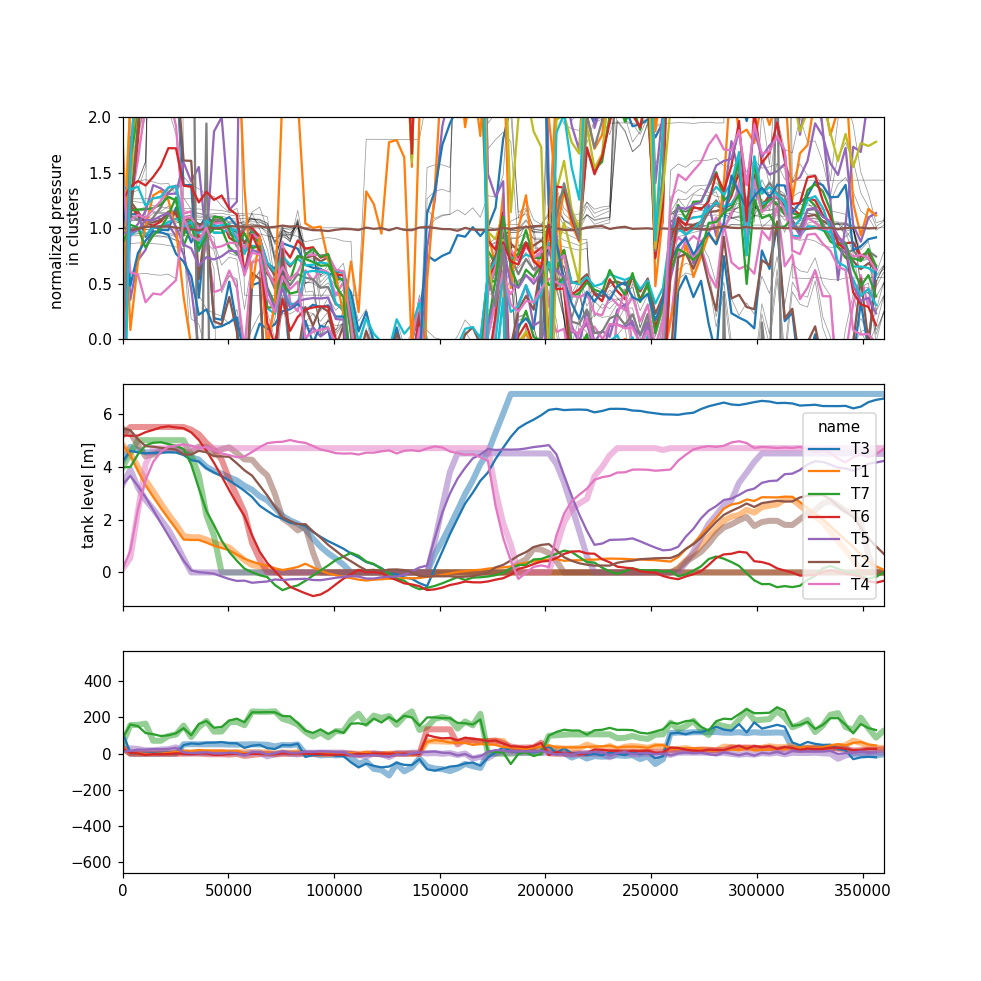

Text(0.5, 0, 'time [s]')

In [68]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

pump_energy.plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylim(0, 2)
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Linear Model

In [69]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [70]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [71]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


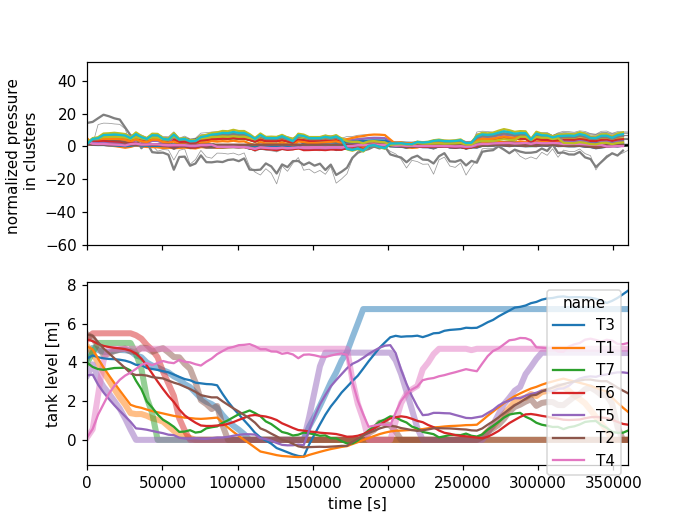

Text(0.5, 0, 'time [s]')

In [72]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res_lin.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Create full training data set:

In [96]:
def scale(X, offset=None, scaling=None, scaling_min=1e-5):
    if np.any(offset) and np.any(scaling):
        X = (X-offset)/scaling
    else:
        offset = X.mean()
        X = X-offset
        scaling = X.abs().max()
        scaling.loc[scaling.abs()<scaling_min] = scaling_min
        X = X/scaling
    return X, offset, scaling

## Load data

In [98]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

In [99]:
nn_input, nn_output = get_data(file_list, 4, cluster_labels, pressure_factor)

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input, nn_output, test_size=0.2)

In [107]:
X_train, input_offset, input_scaling = scale(X_train)
X_test, _, _ = scale(X_test, input_offset, input_scaling)

Y_train, output_offset, output_scaling = scale(Y_train)
Y_test, _, _ = scale(Y_test, output_offset, output_scaling)

## Save everything

Pack everything needed for training in a .pkl file:

In [108]:
training_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'Y_train': Y_train,
    'Y_test': Y_test,
    'x_offset': input_offset,
    'x_scaling': input_scaling,
    'y_offset': output_offset,
    'y_scaling': output_scaling,
    'cluster_labels': cluster_labels,
    'pressure_factor': pressure_factor
}

with open('02_training_setup_narx4.pkl', 'wb') as f:
    results = pickle.dump(training_dict, f)

# Test external model:

In [109]:
model_path = './models/'
model_name = '000_model_01'
model_ext = keras.models.load_model(model_path+model_name+'.h5')

with open('./training_data/02_training_setup_narx4.pkl', 'rb') as f:
    train_data = pickle.load(f)
    

In [110]:
model_ext.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 304)]             0         
_________________________________________________________________
dense (Dense)                (None, 70)                21350     
_________________________________________________________________
dense_1 (Dense)              (None, 42)                2982      
Total params: 24,332
Trainable params: 24,332
Non-trainable params: 0
_________________________________________________________________


In [111]:
x_scaling = train_data['x_scaling']
y_scaling = train_data['y_scaling']
x_offset = train_data['x_offset']
y_offset = train_data['y_offset']

n_arx = 4

x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim = narx_simulator(model_ext, n_arx, x_scaling, y_scaling, x_offset, y_offset, x0, u0, t0)

In [112]:
for k in range(100):
    sys_inputs_now = sys_inputs.iloc[n_arx+k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t)

<IPython.core.display.Javascript object>


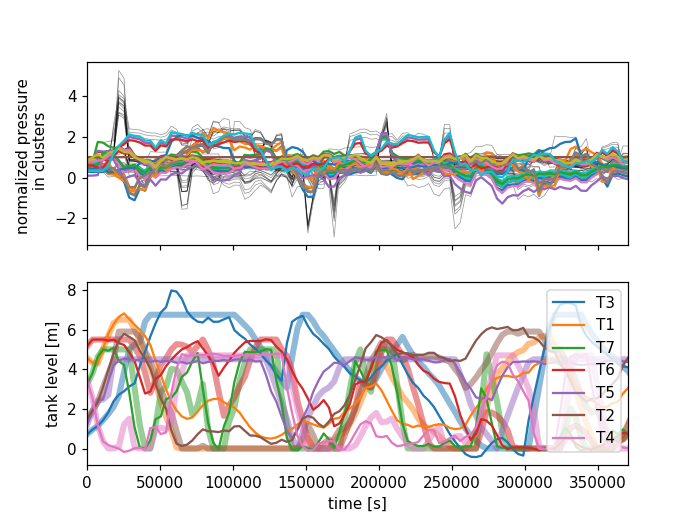

Text(0.5, 0, 'time [s]')

In [113]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')